# Lecture 2 - Image Enhancements

In this notebook, we will discuss several algorithms in enhancing images:
1. Fourier Transform
1. White Balancing
1. Histogram Manipulation

The contents of this notebook is compiled from the following references:

- C Alis,*"Introduction to Digital Image"*, IIP 2018

Organized by:
Benjur Emmanuel L. Borja

---

## 1. Fourier Transform
Images (and signals, in general) can be thought as a superposition of waves or wave patterns. The goal of looking at the fourier transform of an image is to identify periodic patterns and artifacts and mask them in the fourier space to enhance our image. To illustrate this better, let's look at the following images.  First, we have a series of fairly uniform vertical stripes.  Taking the fourier transform of these, we are only left with three dots to our image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

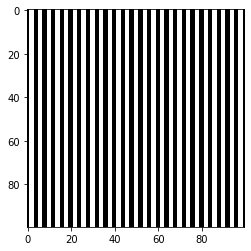

In [2]:
image_lines = np.zeros((100, 100))
image_lines[:,1::4] = 255
image_lines[:,2::4] = 255

plt.imshow(image_lines,cmap='gray')

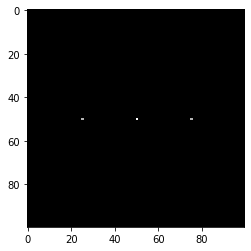

In [3]:
image_lines_fft = np.fft.fftshift(np.fft.fft2(image_lines))

plt.imshow(abs(image_lines_fft),cmap='gray')

Of these three dots: the center corresponding to the DC component, and two dots beside it corresponding to the frequency of the stripes. The shortest spatial wavelength $\lambda_\text{min}$ of stripes that can be represented in the image is 2 pixels. Thus, the largest spatial frequently in the image is $f_\text{max} = 1/\lambda_\text{min} = 1/\text{2 pixels}$. The frequency of the stripes is $f = 1/\text{4 pixels} = f_\text{max}/2$ hence the points are halfway to the edge of the image from the center--the farther from the center, the larger the represented frequency. Most of the changes is along the x-axis hence the dots are arranged horizontally.

What if the stripes are arranged diagonally?

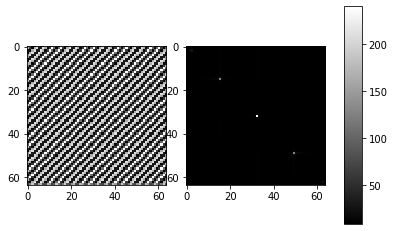

In [4]:
image_diag = imread('stp1.GIF')
image_diag_fft = np.fft.fftshift(np.fft.fft2(image_diag))

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[8,8,1]))
img = ax[0].imshow(image_diag, cmap='gray')
ax[1].imshow(abs(image_diag_fft), cmap='gray')
fig.colorbar(img, cax=ax[2]);

We see here that the points in frequency space are arranged diagonally this time. Evidently, the resulting fourier transform pattern follows the 'direction' of the periodic pattern in the image.  We can also look at the logarithmic Fourier transform to see details beyond the peaks.

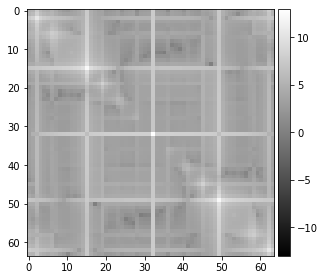

In [5]:
imshow(np.log(abs(image_diag_fft)), cmap='gray');

The three points in the prior Fourier transform are still visible above. They are at grid intersections and the grid structure itself is due to the limitation that the diagonal can only be represented by square pixels of the image.

If we threshold the Fourier transform to only display say those that are at least 5% of the peak, we would get the following.

C:\Users\albertyn.s-carpio\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


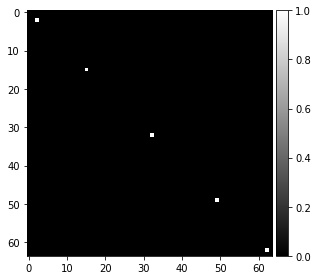

In [6]:
image_diag_mask = abs(image_diag_fft/image_diag_fft.max()) > 0.05
imshow(image_diag_mask, cmap='gray');

The additional points are collinear to the first three points and are multiples of the corresponding frequencies of the first two points. These new points are the harmonic frequencies.

We can transform an image in the frequency domain back to spatial domain using inverse Fourier transform.

C:\Users\albertyn.s-carpio\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


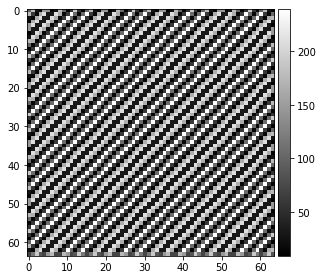

In [7]:
imshow(abs(np.fft.ifft2(image_diag_fft)), cmap='gray');

#### Exercise: What is the expected Fourier transform of the image below?

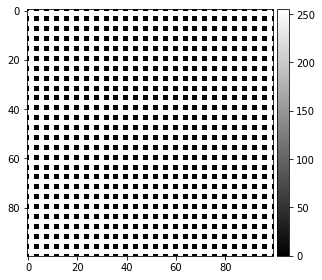

In [8]:
image_grid = np.zeros((100, 100))
image_grid[:,1::4] = 255
image_grid[:,2::4] = 255
image_grid[1::4,:] = 255
image_grid[2::4,:] = 255
imshow(image_grid, cmap='gray');

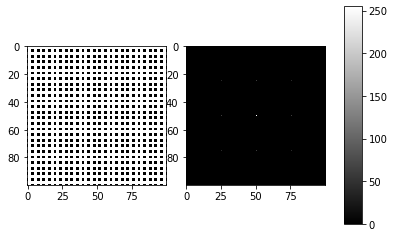

In [9]:
image_grid_fft = np.fft.fftshift(np.fft.fft2(image_grid))

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[8,8,1]))
img = ax[0].imshow(image_grid, cmap='gray')
ax[1].imshow(abs(image_grid_fft), cmap='gray')
fig.colorbar(img, cax=ax[2]);

In the right image above, we see that apart from the DC component in the centre, the frequency representations also form a grid/square pattern around the DC component.

### Modifying images in the frequency domain

Consider the image on the left below and the corresponding logarithmic Fourier transform. Notice how the image on the left contains some horizontal lines all across it's surface. While on the right, we see defined bisecting lines.  The periodic distortion in the original image resulted in these well-defined features in the Fourier-transform space.  When using Image Processing to improve images, this technique involves dealing with such features while in the Fourier-transform space, in order to affect the original image.  For example, here we suppress the vertical line (i.e. draw a black line over it).  Once we invert the transformation, the distortions are gone.

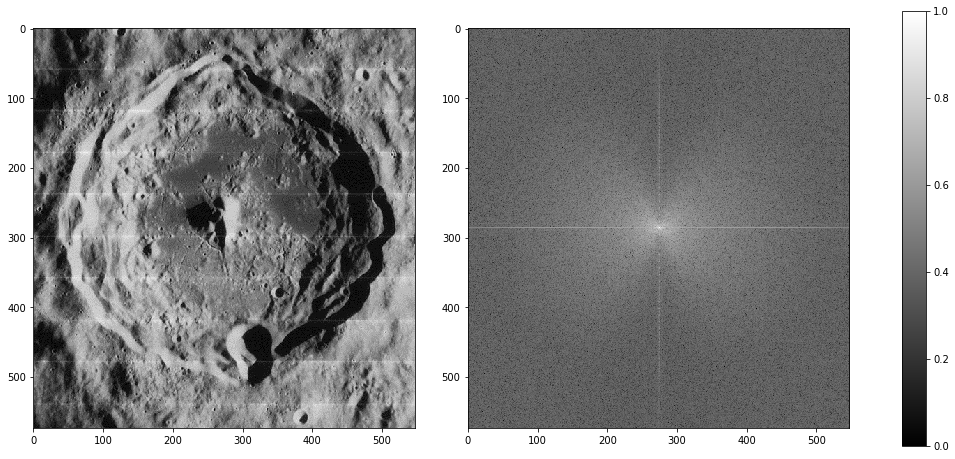

In [10]:
from skimage.color import rgb2gray
orbiter = rgb2gray(imread('lunar_orbiter.jpg'))
orbiter_fft = np.fft.fftshift(np.fft.fft2(orbiter))

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
img = ax[0].imshow(orbiter, cmap='gray')
ax[1].imshow(np.log(abs(orbiter_fft)), cmap='gray')
fig.colorbar(img, cax=ax[2]);

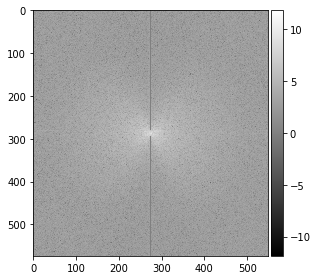

In [11]:
orbiter_fft2 = orbiter_fft.copy()
orbiter_fft2[:280,orbiter_fft.shape[1]//2] = 1
orbiter_fft2[-280:,orbiter_fft.shape[1]//2] = 1
imshow(np.log(abs(orbiter_fft2)), cmap='gray');

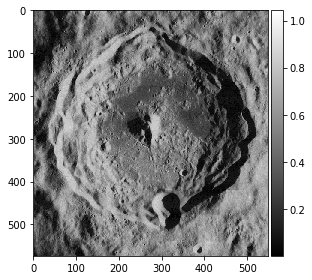

In [12]:
# Run this
imshow(abs(np.fft.ifft2(orbiter_fft2)), cmap='gray');

**Exercise:** Modify the image in the frequency domain to remove artifacts in `moon_image.png`.

<img src="moon_image.png" width="300" />

Now we try it on a more complicated distortion.  We see from the logarithm of the Fourier transform on the right that there are a lot of possibilities for the "periodic artifacts".  In this case, rather than dealing with them individually, we choose a more heavy-handed approach.  We use a circle mask (matrix of zeroes with a region of ones in the shape of a circle) to suppress all but the "activated" areas defined by the mask.  This works because much of the image information is concentrated in the DC-component, and the regions closer to this point.

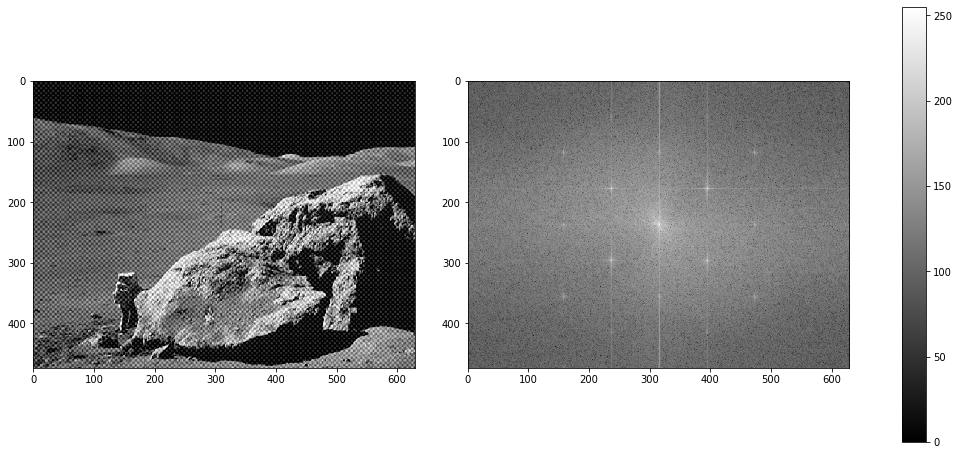

In [13]:
landing = rgb2gray(imread('moon_image.png'))
landing_fft = np.fft.fftshift(np.fft.fft2(landing))

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
img = ax[0].imshow(landing, cmap='gray')
ax[1].imshow(np.log(abs(landing_fft)), cmap='gray')
fig.colorbar(img, cax=ax[2]);

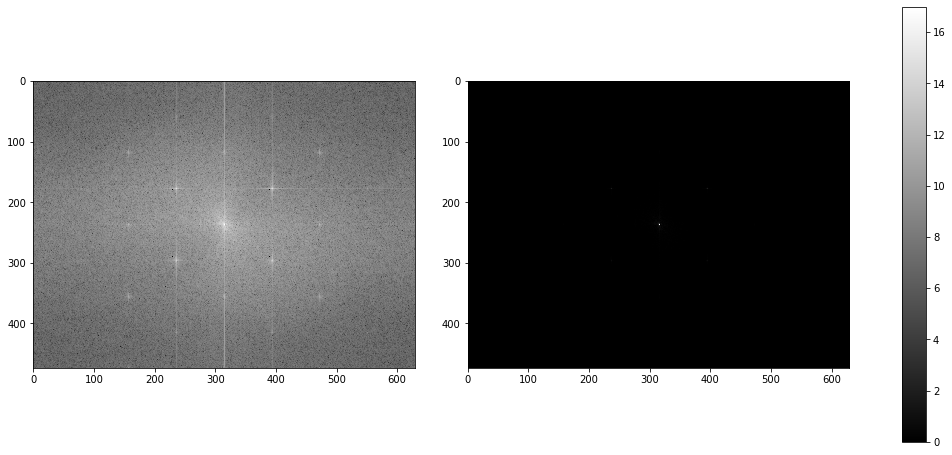

In [14]:
landing_fft2 = landing_fft.copy()

# landing_fft2[:240,landing_fft.shape[1]//2] = 1
# landing_fft2[-240:,landing_fft.shape[1]//2] = 1

landing_fft2[[180, 290], 230] = 1
landing_fft2[[180, 290], 390] = 1

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
img = ax[0].imshow(np.log(abs(landing_fft2)), cmap='gray')
ax[1].imshow(abs(landing_fft2), cmap='gray')
fig.colorbar(img, cax=ax[2]);

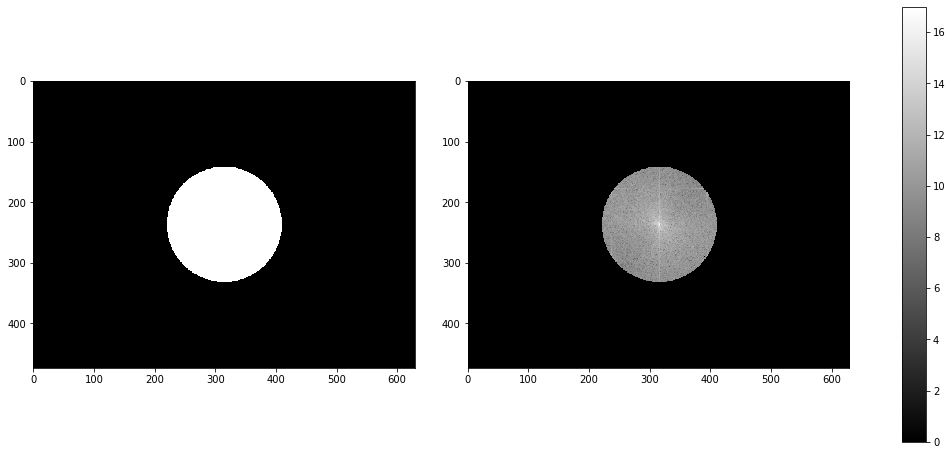

In [15]:
from skimage.draw import circle

circ_image = np.zeros((landing_fft2.shape[0], landing_fft2.shape[1]))
x = landing_fft2.shape[0]//2
y = landing_fft2.shape[1]//2
circ_image[circle(x, y, x*0.4)] = 1

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
landing_fft2[~circ_image.astype(bool)] = 1
img = ax[1].imshow(np.log(abs(landing_fft2)), cmap='gray')
ax[0].imshow(circ_image, cmap='gray')
fig.colorbar(img, cax=ax[2]);

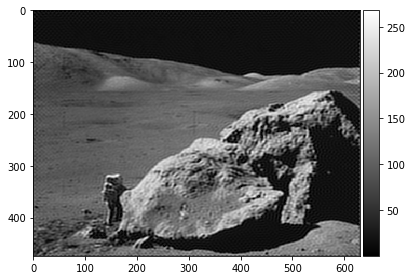

In [16]:
imshow(abs(np.fft.ifft2(landing_fft2)), cmap='gray');

-----

## 2. White Balancing
White balancing is the task of color correcting images by making white or neutral colored regions in the physical world appear as white in the image. In this notebook, we will several methods in white balancing images.

### 2.1 White Patch Algorithm
The white patch algorithm uses the fact that the color white corresponds (in 24-bit images) to (255, 255, 255). That is, white is observed when the values in each RGB channel is maximum. We can therefore independently rescale or normalize each image channel to the maximum allowed value for that channel.

Let's try this algorithm on the image below.

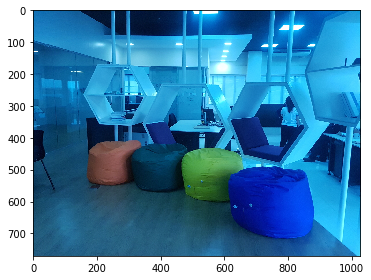

In [61]:
import numpy as np
import skimage.io as skio
from skimage import img_as_ubyte, img_as_float

access = skio.imread('wb_blue.png')
skio.imshow(access);

For this method, we would need to divide each channel by its maximum to white balance.

C:\Users\albertyn.s-carpio\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


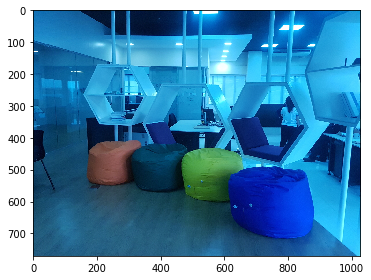

In [18]:
access_wp = img_as_ubyte(access*1.0 / access.max(axis=(0,1)))
skio.imshow(access_wp);

This looks the same as our original image! This would mean that our algorithm didnt work. Let's look at the maximum of each channel:

In [19]:
print('Max value for red channel is: '+str(np.max(access[:,:,0])))
print('Max value for green channel is: '+str(np.max(access[:,:,1])))
print('Max value for blue channel is: '+str(np.max(access[:,:,2])))

Max value for red channel is: 255
Max value for green channel is: 255
Max value for blue channel is: 255


As we can see in the above, the maximum of each channel is already 255.  This means that the individual channel intensities are skewed towards the higher side (nearer 255) of the spectrum--more sections in the image appear white though they may not be in actual.  One way to think about it is that we have 'outliers' in the image intensities.  

To correct this, we look at the histogram of of the pixel values and take the 95th percentile as our maximum value (rescaling our intensities).

In [20]:
import matplotlib.pyplot as plt

0
1
2


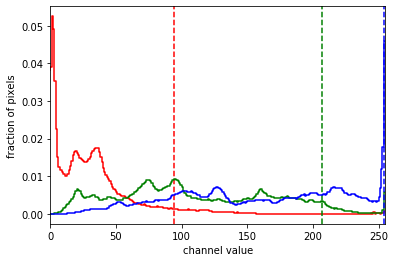

In [21]:
for channel, color in enumerate('rgb'):
    print(channel)
    channel_values = access[:,:,channel]
    plt.step(np.arange(256), 
             np.bincount(channel_values.flatten(), minlength=256)*1.0/
                         channel_values.size, 
             c=color)
    plt.xlim(0, 255)
    plt.axvline(np.percentile(channel_values, 95), ls='--', c=color)
plt.xlabel('channel value')
plt.ylabel('fraction of pixels');

Here we can notice that the maximum value we can consider is now no longer 255, but is instead:

In [22]:
for channel, color in enumerate('RGB'):
    print('99th percentile of %s channel:'%channel, 
          np.percentile(access[:,:,channel], 95))

99th percentile of 0 channel: 94.0
99th percentile of 1 channel: 207.0
99th percentile of 2 channel: 254.0


We can now renormalize our pixel values given this and get:

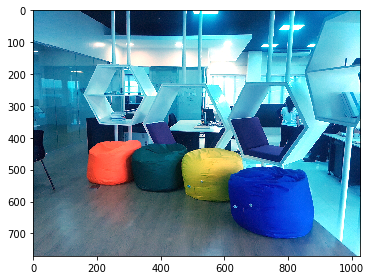

In [23]:
access_wp2 = img_as_ubyte((access*1.0 / np.percentile(access, 95, axis=(0, 1)))
                          .clip(0, 1))
skio.imshow(access_wp2)

There's still a blue hue but it is much better than the original. By adjusting the percentile cap we are able to recover more and more of the original colours of the scene.  However, we also note that more and more of the image gets capped at the max value.

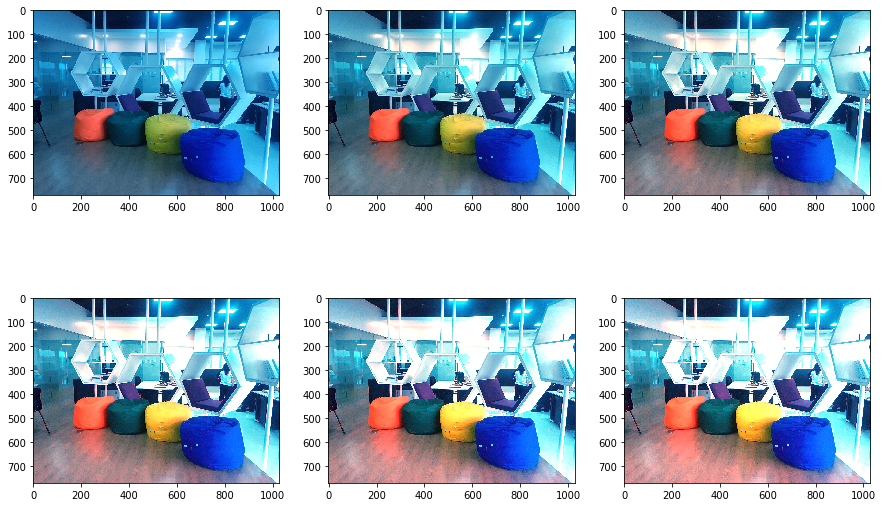

In [62]:
plt.figure(figsize=(15,15))
ranks = [99, 95, 90, 85, 80, 75]
for i, q in enumerate(ranks):
    temp = img_as_ubyte((access*1.0 / np.percentile(access, q, axis=(0, 1)))
                          .clip(0, 1))
    plt.subplot(3,3,i+1), plt.imshow(temp)

### 2.2 Gray-world Algorithm
The gray-world algorithm assumes that on the average, pixels are gray. That is, for every red pixel, there is a green and a blue pixel somewhere in the image. The mean value of each channel therefore should be the same. With that assumption, we can adjust each channel so that its mean value will be the same for all channels. Similar to the white patch algorithm, we normalize the image using the average value of each pixel.

Let's try this algorithm on the image below.

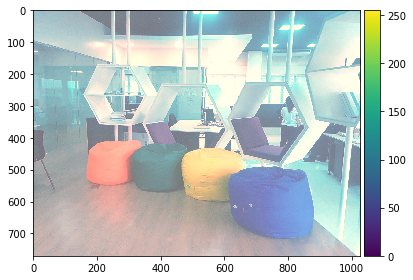

In [24]:
access_gw = ((access * (access.mean() / access.mean(axis=(0, 1))))
             .clip(0, 255).astype(int))
skio.imshow(access_gw);

This looks better but since we divided by the mean, the image becomes washed out. We have removed quite a bit of the blue overcast, but it has muted the other colours as well

### 2.2 Ground-truth Algorithm
Instead of assuming that the brightest areas of an image should be white or that on the average, pixels are gray, we can manually select a "true" white patch and use that to rescale each channel.

Let us select a region of "true" white in the image as shown in the figure below. Notice the difference in the coordinate system of the image and the rectangle.

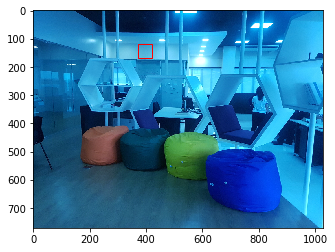

In [25]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
ax.imshow(access)
ax.add_patch(Rectangle((370, 120), 50, 50, edgecolor='r', facecolor='none'));

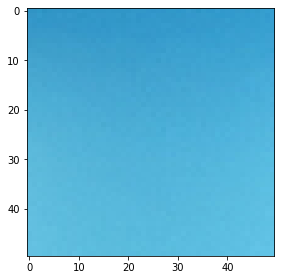

In [26]:
access_patch = access[120:170, 370:420]
skio.imshow(access_patch);

We can normalize each channel of the original image to the the maximum value of each channel of the region.

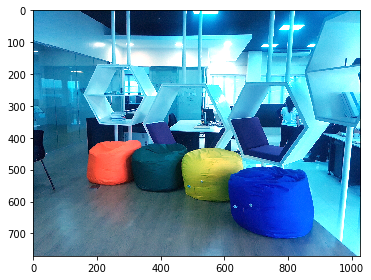

In [27]:
access_gt_max = (access*1.0 / access_patch.max(axis=(0, 1))).clip(0, 1)
skio.imshow(access_gt_max)

Another approach is to make the mean value of each channel of the original image match the mean value of each channel of the region similar to what we did in the gray world algorithm.

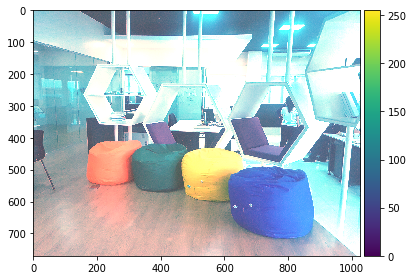

In [28]:
access_gt_mean = ((access * (access_patch.mean() / access.mean(axis=(0, 1))))
                  .clip(0, 255).astype(int))
skio.imshow(access_gt_mean);

#### Exercise:
Implement the three algorithms as a function and apply it to the following image "wb_sepia.png":



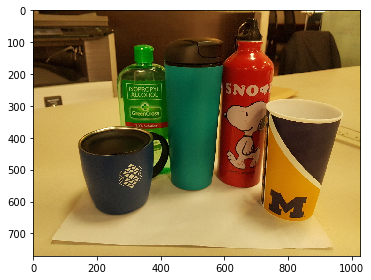

In [29]:
access = skio.imread('wb_sepia2.png')
skio.imshow(access);

In [51]:
def white_patch(image, percentile=100):
    """White balance image using White patch algorithm
    
    Parameters
    ----------
    image : numpy array
        Image to white balance
    percentile : integer, optional
        Percentile value to consider as channel maximum
        
    Returns
    -------
    image_wb : numpy array
        White-balanced image
    """
    image = img_as_ubyte(image*1.0 / image.max(axis=(0,1)))
    return img_as_ubyte(
        (image*1.0 / np.percentile(image, percentile, axis=(0, 1)))
        .clip(0, 1))

In [56]:
def gray_world(image):
    """White balance image using Gray-world algorithm

    Parameters
    ----------
    image : numpy array
        Image to white balance

    Returns
    -------
    image_wb : numpy array
        White-balanced image
    """
    return ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255).astype(int))

In [53]:
def ground_truth(image, patch, mode='mean'):
    """White balance image using Ground-truth algorithm

    Parameters
    ----------
    image : numpy array
        Image to white balance
    patch : numpy array
        Patch of "true" white
    mode : mean or max, optional
        Adjust mean or max of each channel to match patch

    Returns
    -------
    image_wb : numpy array
        White-balanced image
    """
    if mode=='max':
        return (image*1.0 / patch.max(axis=(0, 1))).clip(0, 1)
    else:
        return ((image * (patch.mean() / image.mean(axis=(0, 1))))
                  .clip(0, 255).astype(int))

In the process below, we see again how different techniques affect the image in different ways.  As with many things in Image Processing (which will be underscored across the lecture series) there's a lot of tuning that needs to happen when applying Image Processing techniques to get the optimum result.

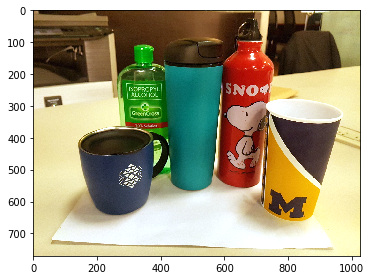

In [54]:
skio.imshow(white_patch(access, 95))

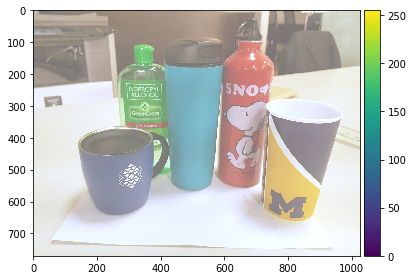

In [57]:
skio.imshow(gray_world(access))

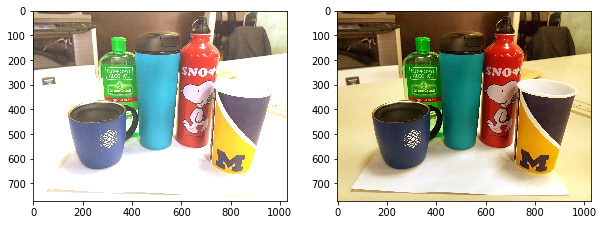

In [59]:
patch = access[600:700, 500:600]
fig, ax = plt.subplots(1,2, figsize=(10,7))
ax[0].imshow(ground_truth(access,patch))
ax[1].imshow(ground_truth(access,patch,'max'))

-----

## 3. Histogram Manipulation
One of the biggest challenges in image detection is image exposure. Images can either be under or overexposed given varying sensor and lighting conditions. 

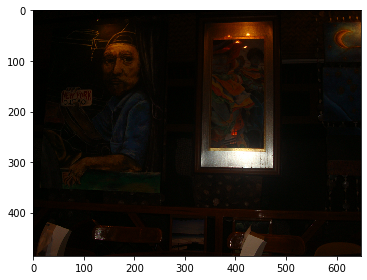

In [33]:
dark_image = imread('dark_image.png')
imshow(dark_image);

Let's try white balancing it using the white patch algorithm.

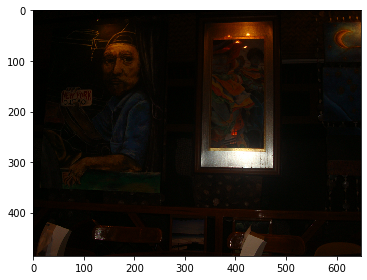

In [44]:
from skimage import img_as_ubyte
dark_image_wb = dark_image *1.0/ dark_image.max(axis=(0,1))
imshow(dark_image_wb);

This means our problem is not a white-balancing issue (we just had to get that our of the way). What we'll do is check the histogram of the pixel values of the image and fix it from there.

### 3.1 Histogram equalization

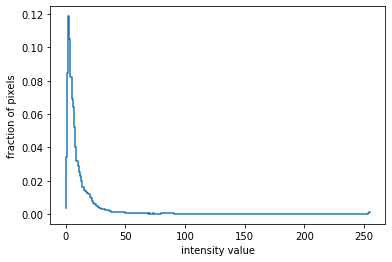

In [45]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution

dark_image_intensity = img_as_ubyte(rgb2gray(dark_image))
freq, bins = histogram(dark_image_intensity)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('intensity value')
plt.ylabel('fraction of pixels');

As expected, most pixels have low intensity values. We want to make the distribution uniform, which is equivalent to making the CDF (blue in the plot below) linear as in the red line below.

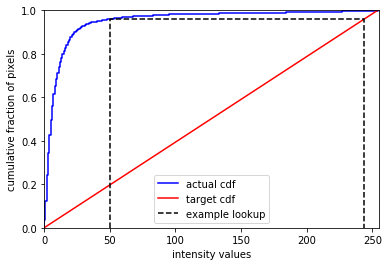

In [46]:
freq, bins = cumulative_distribution(dark_image_intensity)
target_bins = np.arange(255)
target_freq = np.linspace(0, 1, len(target_bins))
plt.step(bins, freq, c='b', label='actual cdf')
plt.plot(target_bins, target_freq, c='r', label='target cdf')
plt.plot([50, 50, target_bins[-11], target_bins[-11]],
         [0, freq[50], freq[50], 0], 
         'k--', 
         label='example lookup')
plt.legend()
plt.xlim(0, 255)
plt.ylim(0, 1)
plt.xlabel('intensity values')
plt.ylabel('cumulative fraction of pixels');

To match the CDFs, what we will do is to compute the percentile of each intensity value then look up the corresponding intensity value having that percentile in the target CDF. We then replace all pixels having that intensity value with the looked up value. For example, the intensity value 50 is in the 95.947th percentile. The intensity value in the 95.947th percentile of the target CDF is 244. We then replace all intensity values of 50 with 244.

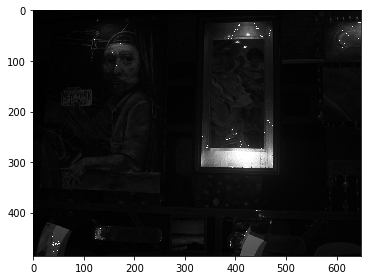

In [47]:
dark_image_244 = dark_image_intensity.copy()
dark_image_244[dark_image_244==50] = 244
imshow(dark_image_244,cmap='gray');

We now do it for all intensity values, using interpolation to create a lookup table.

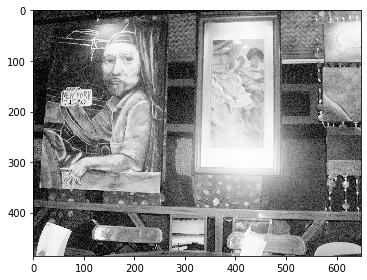

In [48]:
new_vals = np.interp(freq, target_freq, target_bins)
dark_image_eq = img_as_ubyte(new_vals[dark_image_intensity].astype(int))
imshow(dark_image_eq);

### 3.2 More histogram manipulation
The target distribution need not be uniform. Your favorite image editing software most likely has a feature that allows you to specify a target distribution.

Let's try using a Gaussian distribution as the target. Most of the pixels in the resulting image would have middling intensity values and rarely low or high intensity values. This may result in more naturally looking images.


(0, 1.0240751166969813)

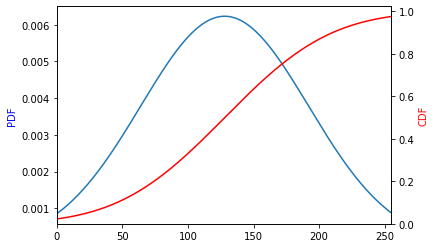

In [39]:
from scipy.stats import norm
gaussian = norm(128, 64)
plt.plot(gaussian.pdf(np.arange(0,256)))
plt.ylabel('PDF', color='b')
plt.twinx()
plt.plot(gaussian.cdf(np.arange(0,256)), c='r')
plt.ylabel('CDF', color='r')
plt.xlim(0, 255)
plt.ylim(ymin=0)

C:\Users\albertyn.s-carpio\Anaconda3\lib\site-packages\skimage\util\dtype.py:184: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


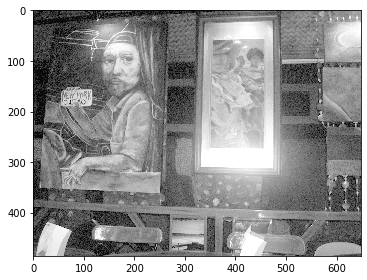

In [40]:
new_vals = np.interp(freq, gaussian.cdf(np.arange(0,256)), np.arange(0,256))
dark_image_gauss = img_as_ubyte(new_vals[dark_image_intensity].astype(int))
imshow(dark_image_gauss);

#### Exercise: Try different sets of Gaussian distribution parameters.

Similar to what we saw with the percentile for the white-balancing, the choice of the Gaussian distribution will affect the frequency mapping of our values, and thereby the final output.  Part of the process will be to find that sweet spot for a particular image.

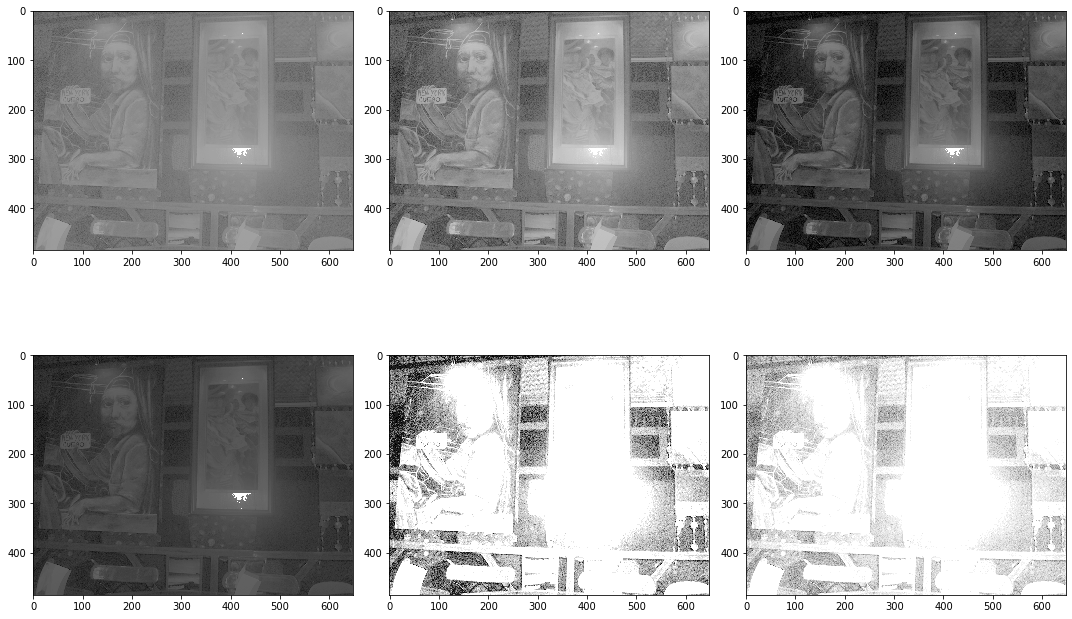

In [50]:
plt.figure(figsize=(15,15))
gauss = [(128, 16), (128, 32), (64,32), (64,16), (256,128), (256,64)]

for ix, n in enumerate(gauss):
    gaussian = norm(n[0], n[1])
    new_vals = np.interp(freq, gaussian.cdf(np.arange(0,256)), np.arange(0,256))
    dark_image_gauss = img_as_ubyte(new_vals[dark_image_intensity].astype(int))
    plt.subplot(3,3,ix+1), imshow(dark_image_gauss)
#     plt.subplot(3,3,ix+1)
#     plt.plot(gaussian.pdf(np.arange(0,256)))
#     plt.ylabel('PDF', color='b')
#     plt.twinx()
#     plt.plot(gaussian.cdf(np.arange(0,256)), c='r')
#     plt.ylabel('CDF', color='r')
#     plt.xlim(0, 255)
#     plt.ylim(ymin=0)

### 3.3 Contrast stretching
Instead of manipulating an image's intensity histogram to match a Gaussian distribution, a similar approach is to rescale the intensities but only those within a range of percentiles. This is known as contrast stretching and we'll use `skimage.exposure.rescale_intensity` to perform it.

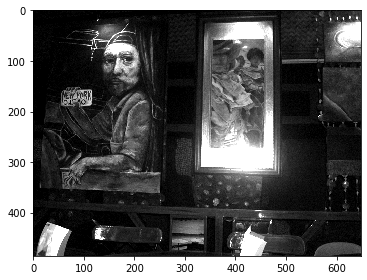

In [42]:
from skimage.exposure import rescale_intensity
# for this example, stretch values between 2nd and 98th percentile
dark_image_contrast = rescale_intensity(dark_image_intensity,
    in_range=tuple(np.percentile(dark_image_intensity, (5, 95))))
imshow(dark_image_contrast);

Looking at its histogram:

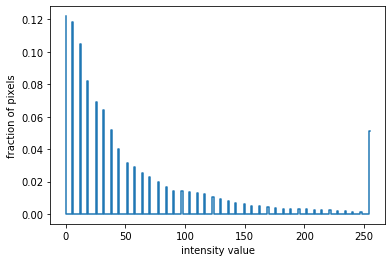

In [43]:
dark_image_intensity = img_as_ubyte(rgb2gray(dark_image_contrast))
freq, bins = histogram(dark_image_intensity)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('intensity value')
plt.ylabel('fraction of pixels');